In [1]:
#main libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#vectorizors
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [3]:
#performence metrics
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [4]:
#modules for building ML model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

## Objective

1. Train, CV, Test split.

2. find right 'c' (1/Lambda) using gridsearchcv(), randomsearchcv().

3. Build logistic regression with featurisation techniques like BOW, TFIDF AVGW2V2 TFIDFW2V and use l1 or l2 regularizor.

4. get accuracy, precision scores, confusion matrrix, recall score, f1 score.

5. report what happens to sparsity when lamda increases using L1 regularizor.

6. get feature importance(check multicollinearity)

In [5]:
#connect sql database
con = sqlite3.connect('final.sqlite')

In [6]:
#read sql data using pandas
data = pd.read_sql("SELECT * FROM REVIEWS", con)

In [7]:
def partition(x) :
    if x == 'positive' :
        return 1
    return 0

actualscore = data['Score']
positivenegative = actualscore.map(partition)
data['Score'] = positivenegative

In [8]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


Number of positive & negative data points are 
 1    307061
0     57110
Name: Score, dtype: int64


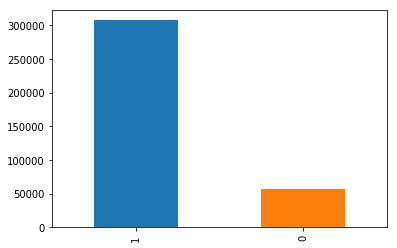

In [9]:
print ('Number of positive & negative data points are \n',data['Score'].value_counts())
data['Score'].value_counts().plot(kind='bar')

In [10]:
#sort data based on time
df_time_sorted = data.sort_values('Time', kind ='quicksort')

In [11]:
df_time_sorted.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


The important piece of information from dataset for building ML models are text reviews and their Scores if they are positive or negative so lets seperate only those two columns into a seperate dataframe using pandas

In [12]:
df = pd.DataFrame(data, columns=['CleanedText', 'Score'])
df.head()

,CleanedText,Score
0,witti littl book make son laugh loud recit car...,1
1,grew read sendak book watch realli rosi movi i...,1
2,fun way children learn month year learn poem t...,1
3,great littl book read nice rhythm well good re...,1
4,book poetri month year goe month cute littl po...,1


In [13]:
#lets check the total dataset values
df.shape

(364171, 2)

Number of +ve & -ve datapoints 
 1    85197
0    14803
Name: Score, dtype: int64


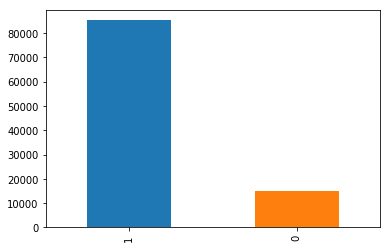

In [14]:
df_sample = df.head(100000)
print ('Number of +ve & -ve datapoints \n' ,df_sample['Score'].value_counts())
df_sample['Score'].value_counts().plot(kind='bar')

In [15]:
X = df_sample['CleanedText']
y = df_sample['Score']
print (X.shape)
print (y.shape)

(100000,)
(100000,)


In [16]:
#test-train-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=False)
print('X_train shape :' ,X_train.shape)
print('y_train shape :' ,y_train.shape)
print('X_test shape :' ,X_test.shape)
print('y_test shape :' ,y_test.shape)

X_train shape : (70000,)
y_train shape : (70000,)
X_test shape : (30000,)
y_test shape : (30000,)


### check if rows are not shuffled since its time series data

In [17]:
X_train.head()

0    witti littl book make son laugh loud recit car...
1    grew read sendak book watch realli rosi movi i...
2    fun way children learn month year learn poem t...
3    great littl book read nice rhythm well good re...
4    book poetri month year goe month cute littl po...
Name: CleanedText, dtype: object

In [18]:
X_test.head()

70000    introduc madhava agav sister back jan diabet r...
70001    love nectar wish amazon would quit rais price ...
70002    purchas particular item twice price local heal...
70003    madhava agav nectar low calori natur kosher sw...
70004    bought replac honey tendenc crystal winter mon...
Name: CleanedText, dtype: object

In [19]:
X_train.tail()

69995    madhava agav nectar amber bottl pack use agav ...
69996    forget aspartam artifici sweetner agav nectar ...
69997    ferment agav nectar realli refresh drink twist...
69998    love stuff liquid dissolv easier low gci proba...
69999    start eat healthier one ago biggest step chang...
Name: CleanedText, dtype: object

In [20]:
X_test.tail()

99995    delici sugar pretti light brown color delici a...
99996    sugar raw flavor profil much better white suga...
99997    use buy sugar year eat much sugar still sugar ...
99998    product exact advertis save least half retail ...
99999    love sugar also get muscavado sugar great use ...
Name: CleanedText, dtype: object

# Functions to find Hyperparameter & Use Logistic Regression

In [21]:
#c=1/lambda, lambda = 0.001,0.002,0.01,0.02,0.1,0.2,1,2,10,20,100,200,1000,2000,10000. 
def log_reg_best_params (X_train, y_train) :
    #c=1/lambda, lambda = 0.001,0.002,0.01,0.02,0.1,0.2,1,2,10,20,100,200,1000,2000,10000. 
    clf = LogisticRegression(n_jobs=-1)
    cv= TimeSeriesSplit(n_splits=10)
    param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], 
                  'penalty':['l1', 'l2']}
    grid_cv = GridSearchCV(clf, param_grid, cv=cv, verbose=1, n_jobs=-1)
    grid_cv.fit(X_train,y_train)
    print("Best HyperParameter: ",grid_cv.best_params_)
    print("Best Accuracy: ", (grid_cv.best_score_*100))

In [22]:
def log_reg(C, penalty, X_train, y_train, X_test, y_test) :
    clf = LogisticRegression(C=C, penalty=penalty, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    print('accuracy_score =', accuracy_score(y_test, y_pred))
    print('precision_score =', precision_score(y_test, y_pred))
    print('recall_score =', recall_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    return y_pred

In [23]:
#c=1/lambda, lambda = 0.001,0.002,0.01,0.02,0.1,0.2,1,2,10,20,100,200,1000,2000,10000. 
def log_reg_best_params_rand (X_train, y_train) :
    #c=1/lambda, lambda = 0.001,0.002,0.01,0.02,0.1,0.2,1,2,10,20,100,200,1000,2000,10000. 
    clf = LogisticRegression(n_jobs=-1)
    cv= TimeSeriesSplit(n_splits=10)
    param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], 
                  'penalty':['l1', 'l2']}
    rand_cv = RandomizedSearchCV(clf, param_grid, cv=cv, verbose=1, n_jobs=-1)
    rand_cv.fit(X_train,y_train)
    print("Best HyperParameter: ",rand_cv.best_params_)
    print("Best Accuracy: ", (rand_cv.best_score_*100))

In [24]:
def log_reg_rand(C, penalty, X_train, y_train, X_test, y_test) :
    clf = LogisticRegression(C=C, penalty=penalty, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    print('accuracy_score =', accuracy_score(y_test, y_pred))
    print('precision_score =', precision_score(y_test, y_pred))
    print('recall_score =', recall_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    return y_pred

# BAG of WORDS

In [25]:
vect = CountVectorizer()

In [26]:
from sklearn import preprocessing
bow_X_train = vect.fit_transform(X_train)
bow_X_train = preprocessing.normalize(bow_X_train)
bow_X_train

<70000x32149 sparse matrix of type '<class 'numpy.float64'>'
	with 2162199 stored elements in Compressed Sparse Row format>

In [27]:
bow_X_test = vect.transform(X_test)
bow_X_test = preprocessing.normalize(bow_X_test)
bow_X_test

<30000x32149 sparse matrix of type '<class 'numpy.float64'>'
	with 880827 stored elements in Compressed Sparse Row format>

In [28]:
log_reg_best_params(bow_X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.8min finished


Best HyperParameter:  {'C': 5, 'penalty': 'l2'}
Best Accuracy:  91.42857142857143


accuracy_score = 0.9231666666666667
precision_score = 0.9378435358783224
recall_score = 0.974418149814199
Wall time: 2.25 s


array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

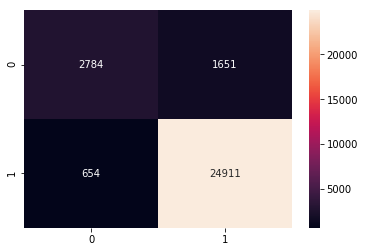

In [29]:
%time log_reg(5, 'l2', bow_X_train, y_train, bow_X_test, y_test)

In [30]:
log_reg_best_params_rand(bow_X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 1}
Best Accuracy:  91.05296243910105


accuracy_score = 0.9206
precision_score = 0.9333433025533665
recall_score = 0.9765695286524545


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

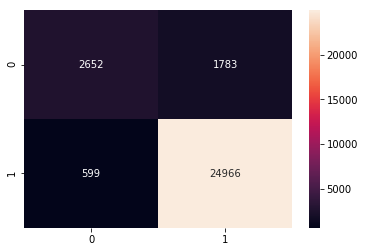

In [31]:
log_reg_rand(1,'l1', bow_X_train, y_train, bow_X_test, y_test)

### Most Important Features BOW

In [48]:
clf = LogisticRegression(C=5, penalty='l2')
clf.fit(bow_X_train, y_train)
y_pred=clf.predict(bow_X_test)
w = clf.coef_ #get weights

In [49]:
bow_1 = CountVectorizer()
bow_2 = bow_1.fit_transform(X_train.values)
clf = LogisticRegression(n_jobs=-1)
#clf = LogisticRegression('C'=5, penalty='l2', n_jobs=-1)
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(w[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(bow_1,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Negative						Positive
________________________________________________________________________________________________
	-10.8883	worst          				8.3558	delici         
	-9.0912	aw             				7.9516	excel          
	-8.7896	terribl        				7.4456	best           
	-8.2298	unfortun       				7.3381	perfect        
	-8.2175	disappoint     				7.3207	addict         
	-8.1568	horribl        				7.1499	great          
	-7.5653	return         				6.1712	awesom         
	-7.2720	threw          				5.7523	amaz           
	-6.7309	wors           				5.6065	love           
	-6.2133	weak           				5.5125	fantast        
	-6.2112	poor           				5.4617	smooth         
	-6.2098	refund         				5.4452	wonder         
	-6.1006	disgust        				5.4398	satisfi        
	-6.0980	cancel         				5.3226	favorit        
	-6.0715	money          				5.2587	beat           
	-5.5979	tasteless      				5.1586	hook           
	-5.5589	stale          				5.0264	hit            
	-5.5399	

# TFIDF

In [33]:
vect = TfidfVectorizer()

In [34]:
from sklearn import preprocessing
tfidf_X_train = vect.fit_transform(X_train)
tfidf_X_train = preprocessing.normalize(tfidf_X_train)
tfidf_X_train

<70000x32149 sparse matrix of type '<class 'numpy.float64'>'
	with 2162199 stored elements in Compressed Sparse Row format>

In [35]:
tfidf_X_test = vect.transform(X_test)
tfidf_X_test = preprocessing.normalize(tfidf_X_test)
tfidf_X_test

<30000x32149 sparse matrix of type '<class 'numpy.float64'>'
	with 880827 stored elements in Compressed Sparse Row format>

In [36]:
log_reg_best_params(tfidf_X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished


Best HyperParameter:  {'C': 5, 'penalty': 'l2'}
Best Accuracy:  91.4018544711614


accuracy_score = 0.9222333333333333
precision_score = 0.9380751244531603
recall_score = 0.9729708585957364


array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

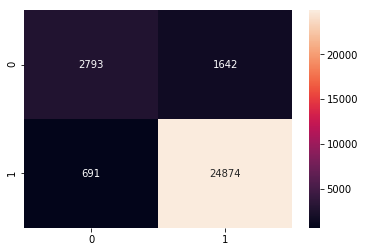

In [37]:
log_reg(5, 'l2', tfidf_X_train, y_train, tfidf_X_test, y_test)

In [38]:
log_reg_best_params_rand(tfidf_X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.1s finished


Best HyperParameter:  {'penalty': 'l1', 'C': 10}
Best Accuracy:  90.54691183404054


accuracy_score = 0.9123666666666667
precision_score = 0.9402303262955855
recall_score = 0.9580676706434579


array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

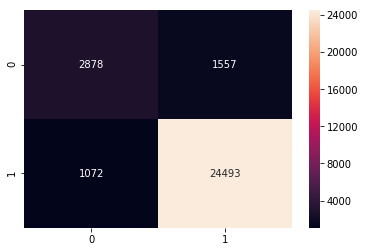

In [39]:
log_reg_rand(10,'l1', tfidf_X_train, y_train, tfidf_X_test, y_test)

### TFIDF most important features

In [51]:
clf = LogisticRegression(C=5, penalty='l2')
clf.fit(tfidf_X_train, y_train)
y_pred=clf.predict(tfidf_X_test)
w = clf.coef_ #get weights

In [52]:
tfidf_1 = TfidfVectorizer()
tfidf_2 = tfidf_1.fit_transform(X_train.values)
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(w[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf_1,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Negative						Positive
________________________________________________________________________________________________
	-9.7700	worst          				12.9037	great          
	-8.8200	disappoint     				10.4799	love           
	-8.0956	terribl        				10.4246	best           
	-8.0913	aw             				10.1971	delici         
	-7.6322	unfortun       				8.7546	perfect        
	-7.5516	horribl        				8.6312	excel          
	-7.3554	return         				6.9972	addict         
	-6.5018	threw          				6.5298	wonder         
	-6.2286	wors           				6.4494	favorit        
	-6.1854	money          				5.9668	good           
	-5.8390	cancel         				5.9133	amaz           
	-5.8279	poor           				5.7594	awesom         
	-5.7092	refund         				5.5030	nice           
	-5.3804	disgust        				5.4475	fantast        
	-5.3183	weak           				5.1223	hook           
	-4.9975	bland          				5.1192	satisfi        
	-4.9177	lack           				5.1091	beat           
	-4.83

# WORD2VECTOR Model

In [40]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

In [41]:
print(X_train.values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [42]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [43]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10848
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'grew', 'read', 'sendak', 'watch', 'realli', 'rosi', 'movi', 'incorpor', 'howev', 'miss', 'hard', 'cover', 'version', 'paperback', 'seem', 'kind', 'flimsi', 'take', 'two', 'hand']


# AVGW2V

### AVGW2V on train data

In [44]:

# average Word2Vec
# compute average word2vec for each review.
%time train_vectors = []; # the avg-w2v for each sentence/review is stored in this li
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
print(len(train_vectors))
print(len(train_vectors[0]))

Wall time: 0 ns
70000
50


In [45]:
avgw2v_train = preprocessing.normalize(train_vectors)

### AVGW2V on test data

In [46]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_in_test=[]
for sent in X_test.values:
    list_of_sent_in_test.append(sent.split())

In [47]:
print(X_test.values[0])
print("*****************************************************************")
print(list_of_sent_in_test[0])

introduc madhava agav sister back jan diabet run famili decid use tea coffe cereal cold hot pass friend famili found also enjoy benefit tast doesnt take much make thing sweet high recommend anyon children well amazon best price
*****************************************************************
['introduc', 'madhava', 'agav', 'sister', 'back', 'jan', 'diabet', 'run', 'famili', 'decid', 'use', 'tea', 'coffe', 'cereal', 'cold', 'hot', 'pass', 'friend', 'famili', 'found', 'also', 'enjoy', 'benefit', 'tast', 'doesnt', 'take', 'much', 'make', 'thing', 'sweet', 'high', 'recommend', 'anyon', 'children', 'well', 'amazon', 'best', 'price']


In [48]:
# average Word2Vec
# compute average word2vec for each review.
test_vectors = []; # the avg-w2v for each sentence/review is stored in this list

for sent in list_of_sent_in_test : # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
print(len(test_vectors))
print(len(test_vectors[0]))

30000
50


In [49]:
avgw2v_test = preprocessing.normalize(test_vectors)

In [50]:
log_reg_best_params(avgw2v_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.6min finished


Best HyperParameter:  {'C': 100, 'penalty': 'l2'}
Best Accuracy:  89.2990727644193


accuracy_score = 0.8959
precision_score = 0.9121428046720047
recall_score = 0.9714062194406415


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

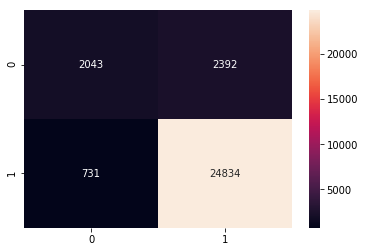

In [51]:
log_reg(100, 'l2', avgw2v_train, y_train, avgw2v_test, y_test)

In [52]:
log_reg_best_params_rand(avgw2v_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.4s finished


Best HyperParameter:  {'penalty': 'l1', 'C': 10}
Best Accuracy:  89.2990727644193


accuracy_score = 0.8958
precision_score = 0.9120725750174459
recall_score = 0.9713671034617641


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

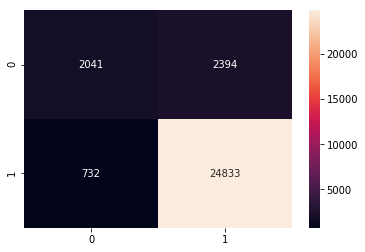

In [53]:
log_reg_rand(10,'l1', avgw2v_train, y_train, avgw2v_test, y_test)

# TFIDFW2V

### TFIDFW2V on Train data

In [58]:
#calculate TFIDF
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(X_train.values)
final_tf_idf = tf_idf_vect.transform(X_test.values)

In [55]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
np.seterr(divide='ignore', invalid='ignore')
tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1
print(len(tfidf_train_vectors))
print(len(tfidf_train_vectors[0]))

70000
50


In [56]:
tfidfw2v_train = preprocessing.normalize(tfidf_train_vectors)
tfidfw2v_train.shape

(70000, 50)

### TFIDFW2V on Test Data

In [59]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
np.seterr(divide='ignore', invalid='ignore')
tfidf_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_in_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1
print(len(tfidf_test_vectors))
print(len(tfidf_test_vectors[0]))


30000
50


In [60]:
tfidfw2v_test = preprocessing.normalize(tfidf_test_vectors)
tfidfw2v_test.shape

(30000, 50)

In [61]:
log_reg_best_params(tfidfw2v_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.5min finished


Best HyperParameter:  {'C': 5, 'penalty': 'l1'}
Best Accuracy:  88.23353763947823


accuracy_score = 0.8845
precision_score = 0.9001883239171374
recall_score = 0.9722667709759437


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

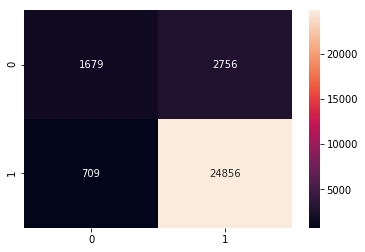

In [62]:
log_reg(5, 'l1', tfidfw2v_train, y_train, tfidfw2v_test, y_test)

In [63]:
log_reg_best_params_rand(tfidfw2v_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 500}
Best Accuracy:  88.23196605374824


accuracy_score = 0.8845666666666666
precision_score = 0.9003115264797508
recall_score = 0.9721885390181889


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

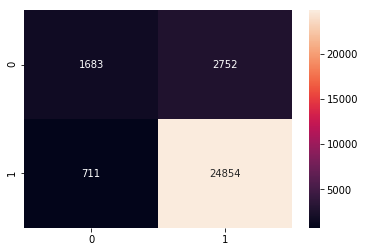

In [64]:
log_reg_rand(500,'l1', tfidfw2v_train, y_train, tfidfw2v_test, y_test)

# 1.5 report what happens to sparsity when lamda increases using L1 regularizor.

#### Theory: as lambda increases sparsity increases(number of zeros in a vector increases)

typical lambda values = #c=1/lambda, lambda = 0.001,0.002,0.01,0.02,0.1,0.2,1,2,10,20,100,200,1000,2000,10000. 

C = 1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001

In [65]:
c = [1000, 100, 50, 10, 0.1]
for i in c :
    clf = LogisticRegression(C=i, penalty='l1')
    clf.fit(bow_X_train, y_train)
    w = clf.coef_ #get weights
    print(f'Number of Non-Zero values in vector for C = {i} with L1 regularization :' ,np.count_nonzero(w)) #no of cells in a vector where values are non-zero

Number of Non-Zero values in vector for C = 1000 with L1 regularization : 13717
Number of Non-Zero values in vector for C = 100 with L1 regularization : 10856
Number of Non-Zero values in vector for C = 50 with L1 regularization : 9552
Number of Non-Zero values in vector for C = 10 with L1 regularization : 5403
Number of Non-Zero values in vector for C = 0.1 with L1 regularization : 201


**Observation**

as we can see number of non zero values decrease i.e number of zeros in a vector increases

# 1.7 get feature importance(check multicollinearity) - Perturbation test

**THEORY**

1. calculate weights vector for the original dataset

2. add some noise to the datapoints

add some noise to our train data points and compare its weight vector with original train dataset

accuracy_score = 0.8522
precision_score = 0.8521950731691056
recall_score = 1.0
number of non-zero elements : 32149


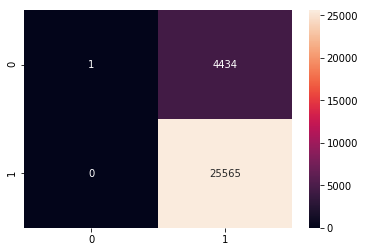

In [77]:
clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(bow_X_train,y_train)
y_pred = clf.predict(bow_X_test)
print('accuracy_score =', accuracy_score(y_test, y_pred))
print('precision_score =', precision_score(y_test, y_pred))
print('recall_score =', recall_score(y_test, y_pred))
print('number of non-zero elements :', np.count_nonzero(clf.coef_))
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [78]:
#Returns non zero elements in a matrix
from scipy.sparse import find #prints only non zero values of sparse vector
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2] #index '0' contains clf, index '1' contains column names, index '2' contains the weights. so we access only weights
print(weights1[:50])

[ 4.09979608e-01  3.97203109e-01 -1.52229597e-03 -1.06615872e-01
  3.45842758e-02  8.20446874e-01 -7.07117433e-01 -7.18519081e-03
  6.68225901e-01  8.27436375e-01 -9.03246688e-02 -1.23465802e+00
 -6.51253244e-02 -3.02791487e-01  7.47239649e-01 -2.35880129e-01
  7.39477572e-02  1.46699966e-01  2.51788983e-01 -9.70569911e-01
  5.95557116e-01  1.77738743e-01  1.25064587e-01 -7.72560048e-02
 -3.74635734e-01 -1.16315742e-01  1.84433998e-01  3.60463431e-01
 -1.06198312e-01  3.90122897e-01  3.91813740e-01 -8.39466264e-02
  1.48051807e+00 -1.38402366e+00  6.84210237e-01  2.20717506e-01
 -8.43710814e-02 -1.17113584e+00  1.15669705e-01  7.03571844e-01
 -2.57068924e+00 -1.08390632e-02  4.97262905e-01  8.48665036e-01
  1.89640309e-01 -4.47008524e-01 -3.68047821e-02  7.71324910e-01
  7.85315190e-01 -1.44494762e-01]


In [79]:
x_train_t = bow_X_train
#Random noise
epsilon = np.random.normal(loc=0, scale=1, size=(find(x_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(x_train_t)
#Introducing random noise to non-zero datapoints
x_train_t[a,b] = epsilon + x_train_t[a,b]

accuracy_score = 0.8522
precision_score = 0.8521950731691056
recall_score = 1.0
number of non-zero elements : 32149


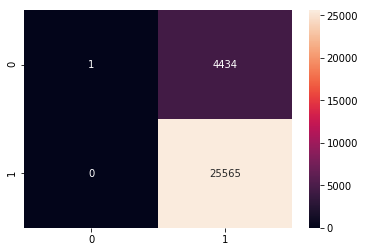

In [80]:
clf = LogisticRegression(C=5, penalty='l2')#c, l2 most outcome hyperparameter
clf.fit(x_train_t, y_train)
y_pred=clf.predict(bow_X_test)
print('accuracy_score =', accuracy_score(y_test, y_pred))
print('precision_score =', precision_score(y_test, y_pred))
print('recall_score =', recall_score(y_test, y_pred))
print('number of non-zero elements :', np.count_nonzero(clf.coef_))
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [81]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[ 0.10929824 -0.35071215 -0.13453866  0.01445846  0.0221669   0.815576
 -0.61465652 -0.06074554  0.20227202  0.42113223 -0.22281701 -0.85095391
 -1.24475461  0.3641009   0.27552457 -0.02410019  0.35196598  0.66865629
  0.28560336  0.76106481 -0.62758307 -0.29645228  0.14901169 -0.13929226
 -0.16133379 -0.30672453  0.56055953  0.25337559 -0.41626678  0.05131717
 -1.18133401 -0.38214096  0.73622731 -0.81980495 -0.46188004  0.29895028
  0.07374555 -2.0231383   0.1522279   0.14681588 -1.02726654 -0.09718674
  0.39095755  1.47426486  0.95612056 -0.2700209  -0.16172987  0.23775194
  1.12352552 -0.63485173]


In [82]:
print(weights1.shape)
print(weights2.shape)

(32149,)
(32149,)


In [83]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100
print(weights_diff[np.where(weights_diff > 30)].size)

14151


##### There are 14151 features that has significantly changed 30%

since w1 and w2 have changed significantly that means multi-collinearity exists in our data.

# RESULTS

In [86]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["MODEL", "C & PENALTY", "ACCURACY", "PRECISION", "RECALL" ]
#BOW
x.add_row(['BOW with LOGISTIC REGRESSION GridSearch', '5 & L2', 0.92, 0.93, 0.97])
x.add_row(["BOW with LOGISTIC REGRESSION Random", '1 & L1', 0.92, 0.93, 0.97])
x.add_row(['--'*5,'-'*5,'-'*8,'-'*5, '--'*5])
#TFIDF
x.add_row(['TFIDF with LOGISTIC REGRESSION GridSearch', '5 & L2', 0.92, 0.93, 0.97])
x.add_row(["TFIDF with LOGISTIC REGRESSION Random", '10 & L1' ,0.91, 0.94, 0.95])
x.add_row(['--'*5,'-'*8,'-'*8,'-'*5, '--'*5])
#AVGW2V
x.add_row(['AVGW2V with LOGISTIC REGRESSION GridSearch', '100 & L2', 0.89, 0.90, 0.97])
x.add_row(["AVGW2V with LOGISTIC REGRESSION Random", '10 & L1', 0.89, 0.90, 0.97])
x.add_row(['--'*5,'-'*8,'-'*8,'-'*5, '--'*5])
#TFIDFW2V
x.add_row(['BOW with LOGISTIC REGRESSION GridSearch', '5 & L1', 0.87, 0.88, 0.97])
x.add_row(["BOW with LOGISTIC REGRESSION Random", '500 & L1', 0.88, 0.90, 0.97])
print(x)

+--------------------------------------------+-------------+----------+-----------+------------+
|                   MODEL                    | C & PENALTY | ACCURACY | PRECISION |   RECALL   |
+--------------------------------------------+-------------+----------+-----------+------------+
|  BOW with LOGISTIC REGRESSION GridSearch   |    5 & L2   |   0.92   |    0.93   |    0.97    |
|    BOW with LOGISTIC REGRESSION Random     |    1 & L1   |   0.92   |    0.93   |    0.97    |
|                 ----------                 |    -----    | -------- |   -----   | ---------- |
| TFIDF with LOGISTIC REGRESSION GridSearch  |    5 & L2   |   0.92   |    0.93   |    0.97    |
|   TFIDF with LOGISTIC REGRESSION Random    |   10 & L1   |   0.91   |    0.94   |    0.95    |
|                 ----------                 |   --------  | -------- |   -----   | ---------- |
| AVGW2V with LOGISTIC REGRESSION GridSearch |   100 & L2  |   0.89   |    0.9    |    0.97    |
|   AVGW2V with LOGISTIC REGRE

In [84]:
#number of positive and negative values in test data
y_test.value_counts()

1    25565
0     4435
Name: Score, dtype: int64

**OBSERVATIONS**

since AVGW2v and TFIDFW2V took too much time for converting to a vector. the total number of datapoints used are limited to 100K. also, the BOW & TFIDF were trained on all data and the confusion matrix and accuracy score were same in percentages. so, having extra data didn't give any significant improvement in overall results so only 100k datapoints are used.


1. The best results were obtained from BOW & TFIDF with closely 2.3k mis-classifications out of 30k datapoints.

2. Logistic Regression model works fantastic in comparison with Naive bayes. where in NB highest accuracy was 88%. but in Logistic Regression it is 92%. Also in Bow the misclassification rate is much lower compared to naive bayes(MultinomialNB)

3. in comparison GridSearchCV() takes more time than RandomizedSearchCV(). but random search was able to produce results faster and in comparison the misclassification is 100 extra with random hyperparameter search.

4. Perturbation test show that there are 14k features that are collinear. may be removing them might give considerable increase in misclassification rate.

5. since this data is imbalanced, there are large amount of data for positive reviews. so, the False positive rate is very high on almost all the vectorizers. W2V perfom very bad on this.